In [ ]:
import SimpleITK as sitk

def register_images_multimodal(fixed_path, moving_path):

    fixed = sitk.ReadImage(fixed_path, sitk.sitkFloat32)
    moving = sitk.ReadImage(moving_path, sitk.sitkFloat32)

    fixed = sitk.RescaleIntensity(fixed, 0, 255)
    moving = sitk.RescaleIntensity(moving, 0, 255)

    initial_transform = sitk.CenteredTransformInitializer(
        fixed,
        moving,
        sitk.Euler2DTransform(),
        sitk.CenteredTransformInitializerFilter.GEOMETRY
    )

    registration = sitk.ImageRegistrationMethod()

    # METRIC
    registration.SetMetricAsMattesMutualInformation(50)
    registration.SetMetricSamplingStrategy(registration.NONE)  

    registration.SetInterpolator(sitk.sitkLinear)

    registration.SetOptimizerAsGradientDescent(
        learningRate=0.5,
        numberOfIterations=300,
        convergenceMinimumValue=1e-6,
        convergenceWindowSize=10
    )
    registration.SetOptimizerScalesFromPhysicalShift()

    registration.SetShrinkFactorsPerLevel([4, 2, 1])
    registration.SetSmoothingSigmasPerLevel([2, 1, 0])
    registration.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

    registration.SetInitialTransform(initial_transform, inPlace=False)

    final_transform = registration.Execute(fixed, moving)

    registered = sitk.Resample(
        moving,
        fixed,
        final_transform,
        sitk.sitkLinear,
        0.0,
        moving.GetPixelID()
    )

    return fixed, moving, registered, final_transform


In [2]:
def evaluate_metrics_multimodal(fixed, moving, registered):

    evaluator = sitk.ImageRegistrationMethod()
    evaluator.SetInterpolator(sitk.sitkLinear)
    evaluator.SetInitialTransform(
        sitk.Transform(fixed.GetDimension(), sitk.sitkIdentity),
        inPlace=False
    )

    evaluator.SetMetricAsMattesMutualInformation(1000)

    mi_before = evaluator.MetricEvaluate(fixed, moving)
    mi_after  = evaluator.MetricEvaluate(fixed, registered)

    print("MULTIMODAL METRICS")
    print(f"MI (Before): {mi_before:.4f}")
    print(f"MI (After):  {mi_after:.4f}")


In [ ]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt

def display_results(fixed, moving, registered, alpha=0.5):

    mri_init = sitk.GetArrayFromImage(fixed)
    ct_init  = sitk.GetArrayFromImage(moving)

    reg = sitk.GetArrayFromImage(registered)

    f = (mri_init - mri_init.min()) / (mri_init.max() - mri_init.min())
    r = (reg - reg.min()) / (reg.max() - reg.min())

    overlay = alpha * f + (1 - alpha) * r

    plt.figure(figsize=(15,8))

    # ---------- INITIAL IMAGES: ----------
    plt.subplot(2,3,1)
    plt.title("MRI Initial")
    plt.imshow(mri_init, cmap="gray")
    plt.axis("off")

    plt.subplot(2,3,2)
    plt.title("CT Initial")
    plt.imshow(ct_init, cmap="gray")
    plt.axis("off")

    plt.subplot(2,3,3)
    plt.axis("off")

    # ---------- REGISTERED RESULTS ----------
    plt.subplot(2,3,4)
    plt.title("Fixed (MRI)")
    plt.imshow(f, cmap="gray")
    plt.axis("off")

    plt.subplot(2,3,5)
    plt.title("Registered (CT)")
    plt.imshow(r, cmap="gray")
    plt.axis("off")

    plt.subplot(2,3,6)
    plt.title("Overlay")
    plt.imshow(overlay, cmap="gray")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


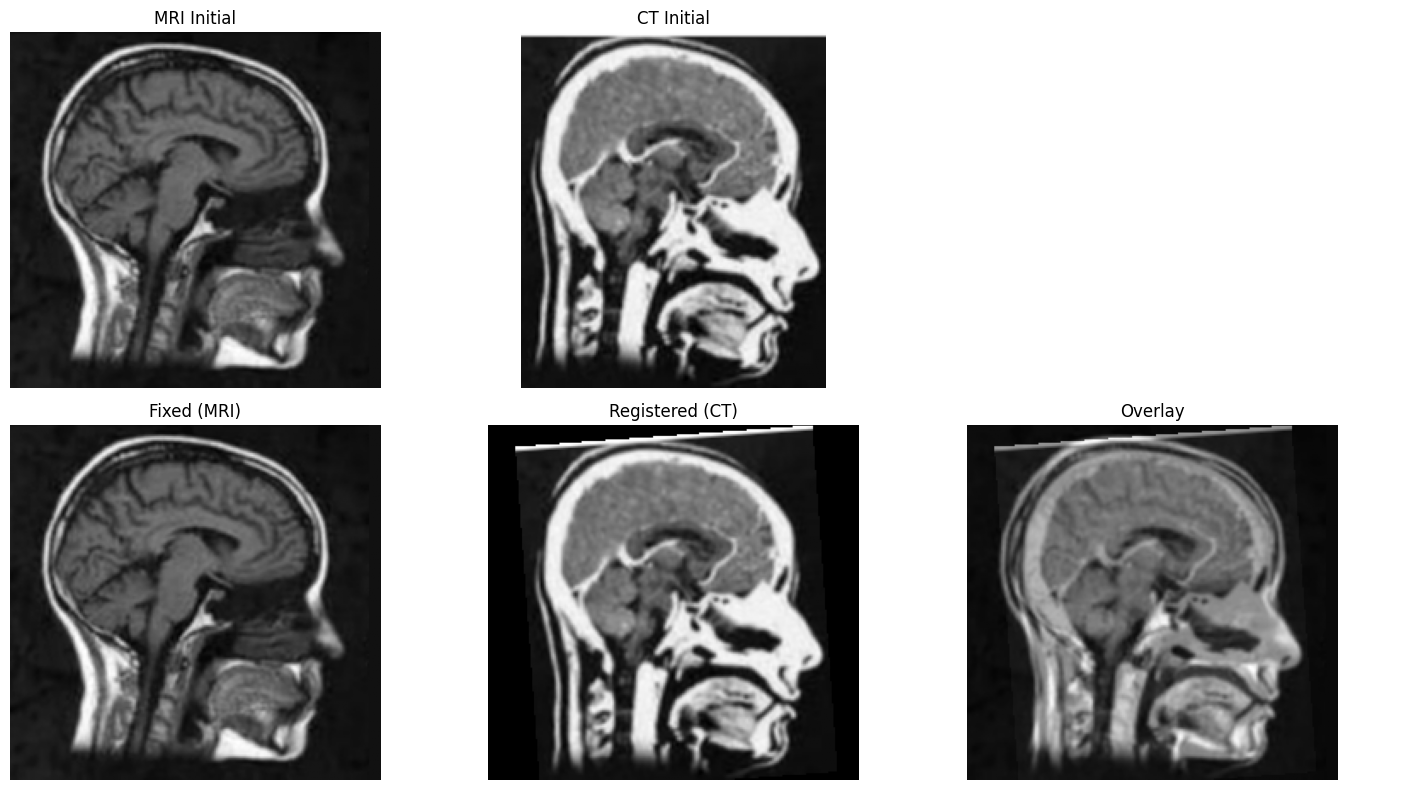

MULTIMODAL METRICS
MI (Before): -0.8686
MI (After):  -1.0450


In [4]:
fixed, moving, registered, tx = register_images_multimodal(
    "Screenshot 2025-12-21 000427.png",
    "Screenshot 2025-12-21 000442.png"
)

display_results(fixed,moving , registered)
evaluate_metrics_multimodal(fixed, moving, registered)
